# Stimulation 1 (biphasic with fractal amplitude, oscillatory amplitude, components)

In [ ]:
import numpy as np
import time
from neuroplatform import StimShape, StimParam, IntanSoftware, Trigger, Experiment, StimPolarity
from fbm import FBM

# Set the experiment token and initialize the experiment
token = "XSALK6J9C4"
exp = Experiment(token)
print(f'Electrodes: {exp.electrodes}')

# Function to generate an oscillatory sequence (e.g., alpha rhythm)
def generate_oscillatory_sequence(length, frequency, min_amplitude, max_amplitude):
    t = np.linspace(0, 1, length)
    oscillatory_sequence = min_amplitude + (max_amplitude - min_amplitude) * np.sin(2 * np.pi * frequency * t)
    return oscillatory_sequence

def generate_fbm_sequence(length, hurst, initial_scale):

    fbm = np.zeros(length+1)
    fbm[0] = 0
    fbm[length] = 0

    def midpoint_displacement(left, right, scale):
        if right - left <= 1:
            return

        mid = (left + right) // 2
        fbm[mid] = 0.5 * (fbm[left] + fbm[right]) + scale * (np.random.rand() - 0.5)

        midpoint_displacement(left, mid, scale / 2 ** hurst)
        midpoint_displacement(mid, right, scale / 2 ** hurst)

    midpoint_displacement(0, length, initial_scale)

    fbm_diff = np.diff(fbm)
    fbm_scaled = np.cumsum(fbm_diff)

    return fbm_scaled

# Generate amplitude sequences
min_amplitude = 1.0
max_amplitude = 8.0
fractal_amplitude = generate_fbm_sequence(8, 0.8, 8) * (max_amplitude - min_amplitude) + min_amplitude
oscillatory_amplitude = generate_oscillatory_sequence(8, 10, min_amplitude, max_amplitude)

# Initialize and configure stimulation parameters
stim_params = []
for index in range(len(exp.electrodes)):
    stim_param = StimParam()
    for key, value in common_stim_param.items():
        setattr(stim_param, key, value)
    stim_param.index = exp.electrodes[index]

    # Use fractal and oscillatory amplitudes directly
    if index % 2 == 0:
        stim_param.phase_amplitude1 = np.maximum(fractal_amplitude[index % len(fractal_amplitude)], 0)
        stim_param.phase_amplitude2 = stim_param.phase_amplitude1
    else:
        stim_param.phase_amplitude1 = np.maximum(oscillatory_amplitude[index % len(oscillatory_amplitude)], 0)
        stim_param.phase_amplitude2 = stim_param.phase_amplitude1

    stim_params.append(stim_param)

# Send stimulation parameters to the IntanSoftware
intan.send_stimparam(stim_params)

# Manual control of the stimulation using a loop
for stim_param in stim_params:
    trigger = np.zeros(8, dtype=np.uint8)  # Adjusted to match the number of electrodes
    trigger[stim_param.index % 8] = 1  # Set trigger for the electrode
    for _ in range(40):  # Send trigger signal 40 times with 5-second intervals
        trigger_gen.send(trigger)
        time.sleep(5)

# Stop raw recording and end the experiment
intan.stop_raw_recording()
exp.stop()

# Cleanup: Close connections and perform any necessary cleanup
trigger_gen.close()
intan.close()                                                                                                                                                        

# Visualize

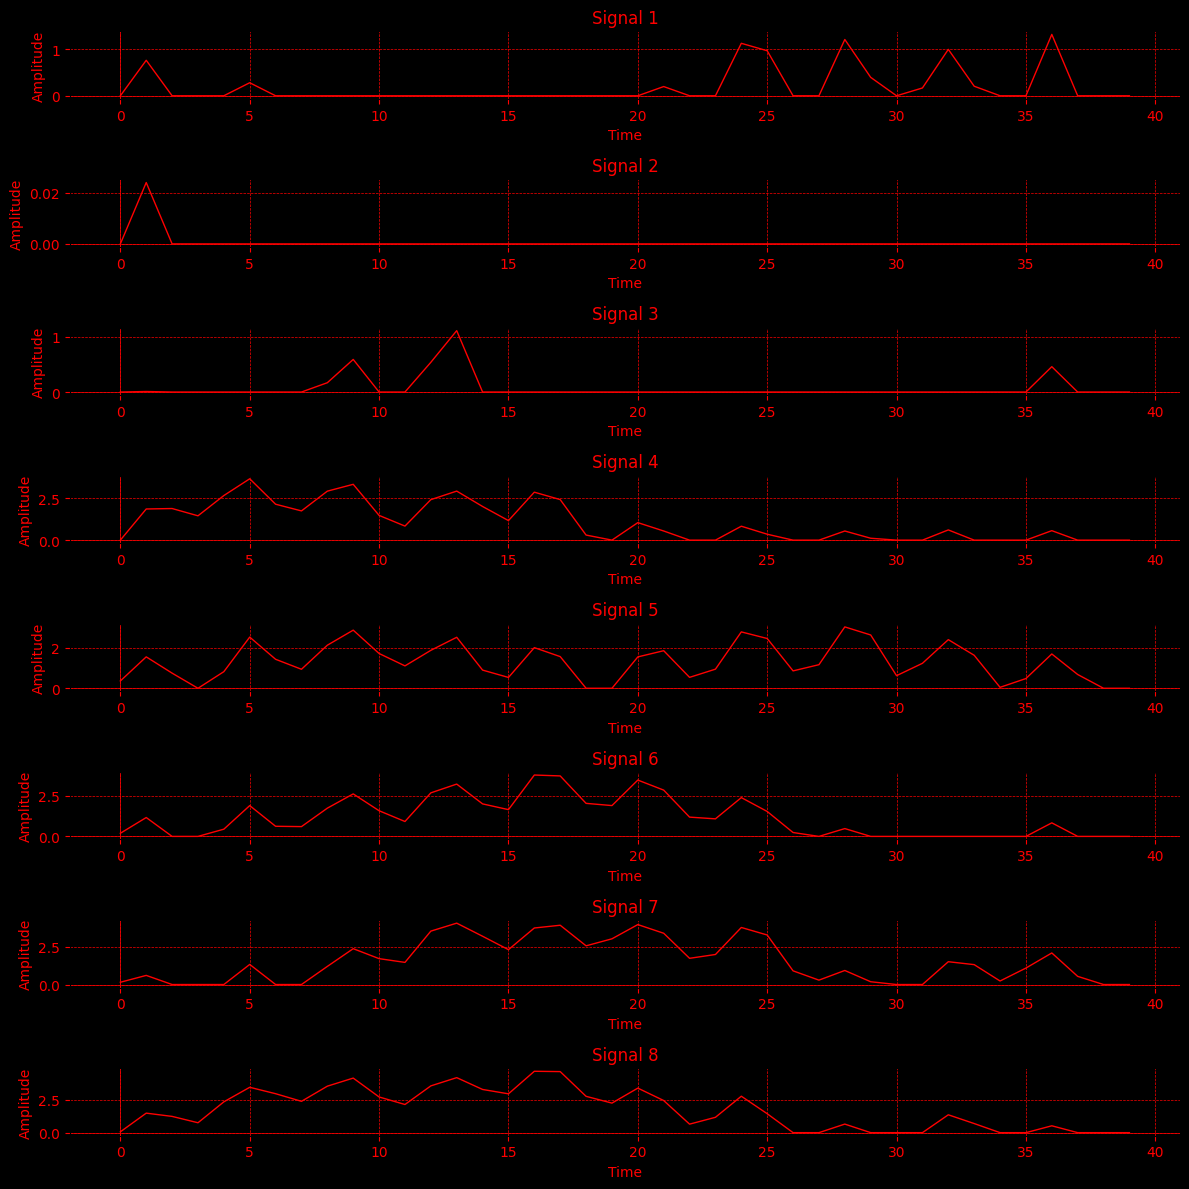

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_oscillatory_sequence(length, frequency, amplitude=1):
    t = np.linspace(0, 1, length)
    oscillatory_sequence = amplitude * np.sin(2 * np.pi * frequency * t)
    return oscillatory_sequence

def generate_fbm_sequence(length, hurst, initial_scale):
    fbm = np.zeros(length+1)
    fbm[0] = 0
    fbm[length] = 0

    def midpoint_displacement(left, right, scale):
        if right - left <= 1:
            return

        mid = (left + right) // 2
        fbm[mid] = 0.5 * (fbm[left] + fbm[right]) + scale * (np.random.rand() - 0.5)

        # Apply scaling adjustment by the Hurst exponent during recursive calls
        midpoint_displacement(left, mid, scale / 2 ** hurst)
        midpoint_displacement(mid, right, scale / 2 ** hurst)

    midpoint_displacement(0, length, initial_scale)

    fbm_diff = np.diff(fbm)
    fbm_scaled = np.cumsum(fbm_diff)

    return fbm_scaled

# Settings to match the stimulation code
num_signals = 8
signal_duration = 40  # Adjusted for visualization

# Visualization
fig = plt.figure(figsize=(12, 12))
fig.set_facecolor('black')

for i in range(num_signals):
    fractal_amplitude = generate_fbm_sequence(signal_duration, 0.8, 8)
    oscillatory_amplitude = generate_oscillatory_sequence(signal_duration, 10, amplitude=1)
    
    # Ensure combined amplitude is non-negative
    combined_amplitude = np.maximum(fractal_amplitude + oscillatory_amplitude, 0)

    ax = plt.subplot(num_signals, 1, i+1)
    ax.plot(combined_amplitude, color='red', linewidth=1.0)
    ax.set_title(f'Signal {i+1}', color='red')
    ax.set_xlabel('Time', color='red')
    ax.set_ylabel('Amplitude', color='red')
    ax.tick_params(axis='both', colors='red')
    ax.set_facecolor('black')
    
    ax.axhline(0, color='red', linewidth=0.5)
    ax.axvline(0, color='red', linewidth=0.5)
    ax.grid(True, color='red', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()